# 0.0 IMPORTS

In [1]:
import warnings
import sweetviz
import pickle

import pandas            as pd
import numpy             as np
import lightgbm          as lgb
import xgboost           as xgb
import seaborn           as sns

from category_encoders       import TargetEncoder
from sklearn.ensemble        import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from datetime                import datetime
from dateutil                import relativedelta
from sklearn.preprocessing   import RobustScaler, MinMaxScaler
from skopt                   import gp_minimize
from pandas_profiling        import ProfileReport

from sklearn                 import model_selection   as ms
from sklearn                 import metrics           as m
from matplotlib              import pyplot            as plt
from imblearn                import combine           as co

C:\Users\mathe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.1 AUX FUNCTIONS

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

def ml_error( model_name, ytest, yhat ):
    f1 = m.f1_score( ytest, yhat )
    precison = m.precision_score( ytest, yhat )
    recall = m.recall_score( ytest, yhat )

    return pd.DataFrame( {'Model name': model_name,
                          'F1': f1,
                          'precison': precison,
                          'recall': recall  }, index=[0] )

def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

def diff_days(d1, d2):
    return (d1.year - d2.year) * 365 + d1.month - d2.month

## 0.2 READ DATASETS

In [3]:
df_cadastral = pd.read_csv('datasets/base_cadastral.csv')
df_info = pd.read_csv('datasets/base_info.csv')
df_pagamentos_desenvolvimento = pd.read_csv('datasets/base_pagamentos_desenvolvimento.csv')
df_pagamentos_teste = pd.read_csv('datasets/base_pagamentos_teste.csv')

In [4]:
# merge datasets
df_completo = df_pagamentos_desenvolvimento.merge( df_cadastral, how='left', on='ID_CLIENTE')
df_completo = df_completo.merge( df_info, how='left', right_on=['ID_CLIENTE','SAFRA_REF'], left_on=['ID_CLIENTE','SAFRA_REF'])

# 1.0 DATA DESCRIPTION

In [5]:
df1 = df_completo.copy()

## 1.1 SHAPE

In [6]:
print( f"Rows: {df1.shape[0]}" )
print( f"Columns: {df1.shape[1]}" )

Rows: 77414
Columns: 16


## 1.2 DATA TYPES

In [7]:
df1.dtypes

ID_CLIENTE                  int64
SAFRA_REF                  object
DATA_EMISSAO_DOCUMENTO     object
DATA_PAGAMENTO             object
DATA_VENCIMENTO            object
VALOR_A_PAGAR             float64
TAXA                      float64
DATA_CADASTRO              object
DDD                        object
FLAG_PF                    object
SEGMENTO_INDUSTRIAL        object
DOMINIO_EMAIL              object
PORTE                      object
CEP_2_DIG                  object
RENDA_MES_ANTERIOR        float64
NO_FUNCIONARIOS           float64
dtype: object

### 1.2.1 CHANGE DTYPES

In [8]:
df1['DATA_EMISSAO_DOCUMENTO'] = pd.to_datetime( df1['DATA_EMISSAO_DOCUMENTO'] )
df1['DATA_PAGAMENTO'] = pd.to_datetime( df1['DATA_PAGAMENTO'] )
df1['DATA_VENCIMENTO'] = pd.to_datetime( df1['DATA_VENCIMENTO'] )
df1['DATA_CADASTRO'] = pd.to_datetime( df1['DATA_CADASTRO'] )

df1['DDD'] = df1['DDD'].apply(lambda x: x.replace("(", "") if type(x) is not float else x)
df1['DDD'] = df1['DDD'].astype(float)

df1['CEP_2_DIG'] = df1['CEP_2_DIG'].apply( lambda x: np.nan if x=="na" else x)
df1['CEP_2_DIG'] = df1['CEP_2_DIG'].astype(float)

## 1.3 CHECK NA

In [9]:
df1.isna().sum()

ID_CLIENTE                    0
SAFRA_REF                     0
DATA_EMISSAO_DOCUMENTO        0
DATA_PAGAMENTO                0
DATA_VENCIMENTO               0
VALOR_A_PAGAR                 0
TAXA                          0
DATA_CADASTRO                 0
DDD                        7414
FLAG_PF                   77195
SEGMENTO_INDUSTRIAL        1417
DOMINIO_EMAIL               898
PORTE                      2476
CEP_2_DIG                     8
RENDA_MES_ANTERIOR         3937
NO_FUNCIONARIOS            3937
dtype: int64

### 1.3.1 FILL NA

In [10]:
df1['FLAG_PF'] = df1['FLAG_PF'].apply( lambda x: 1 if x=='X' else 0)

df1['RENDA_MES_ANTERIOR'] = df1.groupby(['ID_CLIENTE']).ffill()['RENDA_MES_ANTERIOR']
df1['RENDA_MES_ANTERIOR'] = df1['RENDA_MES_ANTERIOR'].fillna(0)

df1['NO_FUNCIONARIOS'] = df1.groupby(['ID_CLIENTE']).ffill()['NO_FUNCIONARIOS']
df1['NO_FUNCIONARIOS'] = df1['NO_FUNCIONARIOS'].fillna(0)

df1 = df1.fillna(0)

## 1.4 DESCRIPTIVE STATISTICS

### 1.4.1 NUMERICAL FEATURES

In [11]:
df1[['VALOR_A_PAGAR','TAXA','RENDA_MES_ANTERIOR','NO_FUNCIONARIOS']].describe().T

,count,mean,std,min,25%,50%,75%,max
VALOR_A_PAGAR,77414.0,46565.460584,46338.921030,0.10,18752.745,34751.35,60884.205,4400000.00
TAXA,77414.0,6.789623,1.798225,4.99,5.990,5.99,6.990,11.99
RENDA_MES_ANTERIOR,77414.0,285130.100938,214887.801446,0.00,126902.000,235330.00,391492.000,1682759.00
NO_FUNCIONARIOS,77414.0,115.212093,25.020656,0.00,105.000,117.00,130.000,198.00


### 1.4.2 CATEGORICAL FEATURES

In [12]:
df1[['DOMINIO_EMAIL','SEGMENTO_INDUSTRIAL','PORTE']].describe().T

,count,unique,top,freq
DOMINIO_EMAIL,77414,7,YAHOO,25322
SEGMENTO_INDUSTRIAL,77414,4,Serviços,31638
PORTE,77414,4,MEDIO,29929


# 2.0 DATA FILTERING

In [13]:
df2 = df1.copy()

# 3.0 FEATURE ENGINEERING

In [14]:
df3 = df2.copy()

In [15]:
# creating target variable
df3['tempo_sem_pagar'] = df3['DATA_PAGAMENTO'] - df3['DATA_VENCIMENTO']
df3['tempo_sem_pagar'] = df3['tempo_sem_pagar'].dt.days
df3['inadimplente'] = df3['tempo_sem_pagar'].apply( lambda x: 0 if x < 5 else 1)

In [16]:
df3['prazo_em_dias'] = df3['DATA_VENCIMENTO'] - df3['DATA_EMISSAO_DOCUMENTO']
df3['prazo_em_dias'] = df3['prazo_em_dias'].dt.days

df3['meses_desde_cadastro'] = df3.apply( lambda x: diff_month(x.DATA_EMISSAO_DOCUMENTO, x.DATA_CADASTRO), axis=1)
df3['dias_desde_cadastro'] = df3.apply( lambda x: diff_days(x.DATA_EMISSAO_DOCUMENTO, x.DATA_CADASTRO), axis=1)

df3['valor_emprestimo'] = df3.apply( lambda x: x['VALOR_A_PAGAR'] / (1 + x['TAXA'] / 100), axis=1 )

df3['diff_renda'] = df3['RENDA_MES_ANTERIOR'] - df3['VALOR_A_PAGAR']

df3['len_credit_history'] = np.nan
for id in df3['ID_CLIENTE'].unique():
    len_credit_history = len(df3.loc[df3['ID_CLIENTE']==id])
    df3.loc[df3['ID_CLIENTE']==id, 'len_credit_history'] = len_credit_history

df3 = df3.assign(ultima_data_emprestimo=df3.groupby('ID_CLIENTE').DATA_EMISSAO_DOCUMENTO.apply(lambda x: x.diff().dt.days))
df3['ultima_data_emprestimo'] = df3['ultima_data_emprestimo'].fillna(0)

# 4.0 EDA

In [17]:
df4 = df3.copy()

In [18]:
# # generating pandas profile report
# profile = ProfileReport(df4)
# profile.to_file('eda-analysis.html')

# 5.0 DATA PREPARATION

In [19]:
df5 = df3.copy()
df5.drop( columns=['tempo_sem_pagar','DATA_PAGAMENTO'], inplace=True )

## 5.1 Encoding

In [20]:
# target encoder
te = TargetEncoder()

df5['SAFRA_REF'] = df5['SAFRA_REF'].astype(str)
df5['DATA_EMISSAO_DOCUMENTO'] = df5['DATA_EMISSAO_DOCUMENTO'].astype(str)
df5['DATA_VENCIMENTO'] = df5['DATA_VENCIMENTO'].astype(str)
df5['DATA_CADASTRO'] = df5['DATA_CADASTRO'].astype(str)

df5['SEGMENTO_INDUSTRIAL'] = te.fit_transform( df5['SEGMENTO_INDUSTRIAL'], df5['inadimplente'] )
pickle.dump( te, open( 'encoders/segmento_industrial_encoding', 'wb') )

df5['DOMINIO_EMAIL'] = te.fit_transform( df5['DOMINIO_EMAIL'], df5['inadimplente'] )
pickle.dump( te, open( 'encoders/dominio_email_encoding', 'wb') )

df5['PORTE'] = te.fit_transform( df5['PORTE'], df5['inadimplente'] )
pickle.dump( te, open( 'encoders/porte_encoding', 'wb') )

df5['SAFRA_REF'] = te.fit_transform( df5['SAFRA_REF'], df5['inadimplente'] )
pickle.dump( te, open( 'encoders/safra_ref_encoding', 'wb') )

df5['DATA_EMISSAO_DOCUMENTO'] = te.fit_transform( df5['DATA_EMISSAO_DOCUMENTO'], df5['inadimplente'] )
pickle.dump( te, open( 'encoders/data_emissao_documento_encoding', 'wb') )

df5['DATA_VENCIMENTO'] = te.fit_transform( df5['DATA_VENCIMENTO'], df5['inadimplente'] )
pickle.dump( te, open( 'encoders/data_vencimento_encoding', 'wb') )

df5['DATA_CADASTRO'] = te.fit_transform( df5['DATA_CADASTRO'], df5['inadimplente'] )
pickle.dump( te, open( 'encoders/data_cadastro_encoding', 'wb') )

## 5.2 Rescaling

In [21]:
# Min Max Scaler
mms = MinMaxScaler()

df5['TAXA'] = mms.fit_transform( df5[['TAXA']].values )
pickle.dump( mms, open( 'scalers/TAXA_scaler', 'wb') )

df5['CEP_2_DIG'] = mms.fit_transform( df5[['CEP_2_DIG']].values )
pickle.dump( mms, open( 'scalers/CEP_2_DIG_scaler', 'wb') )	

df5['NO_FUNCIONARIOS'] = mms.fit_transform( df5[['NO_FUNCIONARIOS']].values )
pickle.dump( mms, open( 'scalers/NO_FUNCIONARIOS_scaler', 'wb') )	

df5['prazo_em_dias'] = mms.fit_transform( df5[['prazo_em_dias']].values )
pickle.dump( mms, open( 'scalers/prazo_em_dias_scaler', 'wb') )
# 	
df5['dias_desde_cadastro'] = mms.fit_transform( df5[['dias_desde_cadastro']].values )
pickle.dump( mms, open( 'scalers/dias_desde_cadastro_scaler', 'wb') )	

df5['len_credit_history'] = mms.fit_transform( df5[['len_credit_history']].values )
pickle.dump( mms, open( 'scalers/len_credit_history_scaler', 'wb') )

df5['ultima_data_emprestimo'] = mms.fit_transform( df5[['ultima_data_emprestimo']].values )
pickle.dump( mms, open( 'scalers/ultima_data_emprestimo_scaler', 'wb') )	

# Robust Scaler
rs = RobustScaler()

df5['VALOR_A_PAGAR'] = rs.fit_transform( df5[['VALOR_A_PAGAR']].values )
pickle.dump( mms, open( 'scalers/VALOR_A_PAGAR_scaler', 'wb') )	

df5['RENDA_MES_ANTERIOR'] = rs.fit_transform( df5[['RENDA_MES_ANTERIOR']].values )
pickle.dump( mms, open( 'scalers/RENDA_MES_ANTERIOR_scaler', 'wb') )	

df5['valor_emprestimo'] = rs.fit_transform( df5[['valor_emprestimo']].values )
pickle.dump( mms, open( 'scalers/valor_emprestimo_scaler', 'wb') )	

df5['diff_renda'] = rs.fit_transform( df5[['diff_renda']].values )
pickle.dump( mms, open( 'scalers/diff_renda_scaler', 'wb') )

# 6.0 FEATURE SELECTION

In [22]:
# model
forest = ExtraTreesClassifier( n_jobs=-1 )

# training
X = df5.drop(columns=['inadimplente'])
Y = df5['inadimplente'].values

x_train_fselection, x_val, y_train_fselection, y_val = ms.train_test_split( X, Y, test_size=0.5, random_state=42 )

forest.fit( x_train_fselection, y_train_fselection )

ExtraTreesClassifier(n_jobs=-1)

Feature Ranking:

                  feature  importance
0           DATA_CADASTRO    0.169021
0         DATA_VENCIMENTO    0.090579
0  DATA_EMISSAO_DOCUMENTO    0.067676
0           VALOR_A_PAGAR    0.062678
0        valor_emprestimo    0.062215
0           prazo_em_dias    0.061433
0    meses_desde_cadastro    0.041669
0     dias_desde_cadastro    0.040118
0              diff_renda    0.040039
0  ultima_data_emprestimo    0.039322
0               SAFRA_REF    0.037737
0         NO_FUNCIONARIOS    0.036769
0      len_credit_history    0.036683
0      RENDA_MES_ANTERIOR    0.034814
0                     DDD    0.029579
0                    TAXA    0.029215
0                   PORTE    0.027144
0               CEP_2_DIG    0.026900
0              ID_CLIENTE    0.026490
0           DOMINIO_EMAIL    0.021509
0     SEGMENTO_INDUSTRIAL    0.017537
0                 FLAG_PF    0.000872


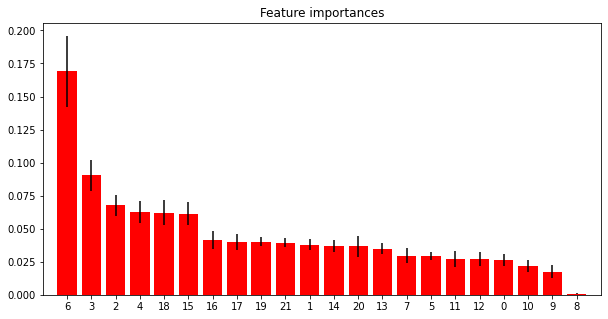

In [23]:
importances = forest.feature_importances_
std = np.std( [tree.feature_importances_ for tree in forest.estimators_], axis=0 )
indices = np.argsort( importances )[::-1]

# print the feature ranking
df = pd.DataFrame()

print( 'Feature Ranking:\n' )
for i, j in zip( x_train_fselection,forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) ) 

# plot the impurity-based feature importances of the forest
plt.figure(figsize=(10,5))
plt.title( 'Feature importances' )
plt.bar( range( x_train_fselection.shape[1] ), importances[indices], color='r', yerr=std[indices], align='center' )
plt.xticks( range(x_train_fselection.shape[1]), indices )
plt.xlim( [-1, x_train_fselection.shape[1]] )
plt.show()

In [24]:
columns_to_delete = ['inadimplente']

# 7.0 HANDLING IMBALANCED DATA

In [25]:
df_features = df5.drop( columns=columns_to_delete)
df_target = df5['inadimplente'].copy()

In [26]:
# define
smt = co.SMOTETomek()

# apply
features_smtk, target_smtk = smt.fit_resample( df_features, df_target )

# 8.0 MACHINE LEARNING

In [27]:
X = features_smtk
Y = target_smtk

X_train, X_val, y_train, y_val = ms.train_test_split( X, Y, test_size=0.2, random_state=42 )

## 8.1 LightGBM

In [28]:
# model
model_lgb = lgb.LGBMClassifier( n_jobs=-1, random_state=42 ).fit( X_train, y_train )

# prediction
yhat_lgb = model_lgb.predict( X_val )

# performance
model_lgb_results = ml_error( 'LightGBM',  y_val, yhat_lgb )
model_lgb_results

,Model name,F1,precison,recall
0,LightGBM,0.965661,0.962547,0.968796


### 8.1.1 Cross Validation

In [29]:
# cross validation
kfold = KFold(n_splits=5, random_state=1, shuffle=True)
cv = cross_val_score(model_lgb, X, Y, scoring='f1', cv=kfold, n_jobs=-1, error_score='raise' )
print( "{} +/- {}".format( np.mean(cv), np.std(cv) ))

0.965353382007106 +/- 0.0011347876851115443


## 8.2 XGBoost

In [30]:
# model
model_xgb = xgb.XGBClassifier( n_jobs=-1, random_state=42 ).fit( X_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( X_val )

# performance
model_xgb_results = ml_error( 'XGBoost',  y_val, yhat_xgb )
model_xgb_results

,Model name,F1,precison,recall
0,XGBoost,0.976444,0.974814,0.97808


### 8.2.1 Cross Validation

In [31]:
# cross validation
kfold = KFold(n_splits=5, random_state=1, shuffle=True)
cv = cross_val_score(model_xgb, X, Y, scoring='f1', cv=kfold, n_jobs=-1, error_score='raise' )
print( "{} +/- {}".format( np.mean(cv), np.std(cv) ))

0.9762555445855238 +/- 0.0006451408999156162


## 8.3 Random Forest Classifier

In [32]:
# model
model_rf = RandomForestClassifier( n_jobs=-1, random_state=42 ).fit( X_train, y_train )

# prediction
yhat_rf = model_rf.predict( X_val )

# performance
model_rf_results = ml_error( 'Random Forest',  y_val, yhat_rf )
model_rf_results

,Model name,F1,precison,recall
0,Random Forest,0.980455,0.973505,0.987504


### 8.3.1 Cross Validation

In [33]:
# cross validation
kfold = KFold(n_splits=5, random_state=1, shuffle=True)
cv = cross_val_score(model_rf, X, Y, scoring='f1', cv=kfold, n_jobs=-1, error_score='raise' )
print( "{} +/- {}".format( np.mean(cv), np.std(cv) ))

0.9800818003071574 +/- 0.0009492414664711094


## 8.4 Extra Trees Classifier

In [34]:
# model
model_et = ExtraTreesClassifier( n_jobs=-1, random_state=42 ).fit( X_train, y_train )

# prediction
yhat_et = model_et.predict( X_val )

# performance
model_et_results = ml_error( 'Extra Trees',  y_val, yhat_et )
model_et_results

,Model name,F1,precison,recall
0,Extra Trees,0.986343,0.979552,0.993229


### 8.3.1 Cross Validation

In [35]:
# cross validation
kfold = KFold(n_splits=5, random_state=1, shuffle=True)
cv = cross_val_score(model_et, X, Y, scoring='f1', cv=kfold, n_jobs=-1, error_score='raise' )
print( "{} +/- {}".format( np.mean(cv), np.std(cv) ))

0.9861646185926481 +/- 0.0005651692887522739


# 9.0 HYPERPARAMETER FINE TUNING - BAYESIAN OPTIMIZATION

## 9.1.1 XGBoost

In [36]:
search_space = [(100, 1500), #n_estimators
                (1, 9), #gamma, 
                (1, 180),#reg_alpha
                (1, 10), #min_child_weight
                (0.15, 1.0) #colsample_bytree
]

def treinar_modelo( params ):
    n_estimators = params[0]
    gamma = params[1]
    reg_alpha = params[2]
    min_child_weight = params[3]
    colsample_bytree = params[4]

    print(params, '\n')

    xgb_model = xgb.XGBClassifier( n_estimators=n_estimators, gamma=gamma, reg_alpha=reg_alpha, min_child_weight=min_child_weight, colsample_bytree=colsample_bytree, n_jobs=-1, random_state=42)
    xgb_model.fit( X_train, y_train )

    yhat_xgb = xgb_model.predict( X_val )

    return -m.f1_score( y_val, yhat_xgb )

result = gp_minimize( treinar_modelo, search_space, n_calls = 50, n_initial_points = 10, verbose=True, n_jobs=-1, random_state= 42 )

Iteration No: 1 started. Evaluating function at random point.
[1215, 2, 141, 6, 0.5289578399255526] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 36.3585
Function value obtained: -0.9507
Current minimum: -0.9507
Iteration No: 2 started. Evaluating function at random point.
[240, 5, 61, 2, 0.703255202006525] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 20.4561
Function value obtained: -0.9618
Current minimum: -0.9618
Iteration No: 3 started. Evaluating function at random point.
[179, 7, 169, 1, 0.9933798253975351] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 12.8464
Function value obtained: -0.9444
Current minimum: -0.9618
Iteration No: 4 started. Evaluating function at random point.
[964, 6, 2, 1, 0.5960584612196308] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 167.3200
Function value obtained: -0.9786
Current minimum: -0.9786
Iteration No: 5 started. Evaluating function at random point.


In [37]:
result.x

[809, 1, 1, 2, 0.9565531991683504]

In [45]:
# training final model tuned
model_xgb = xgb.XGBClassifier( n_estimators=809, gamma=1, reg_alpha=1, min_child_weight=2,
                              colsample_bytree=0.9565531991683504, n_jobs=-1, random_state=42 ).fit( X_train, y_train )
pickle.dump( model_xgb, open( 'model/model.pkl', 'wb' ) )